✅ Données fusionnées : 4966
✅ Données enrichies : 2814
📊 Pays filtrés : 58


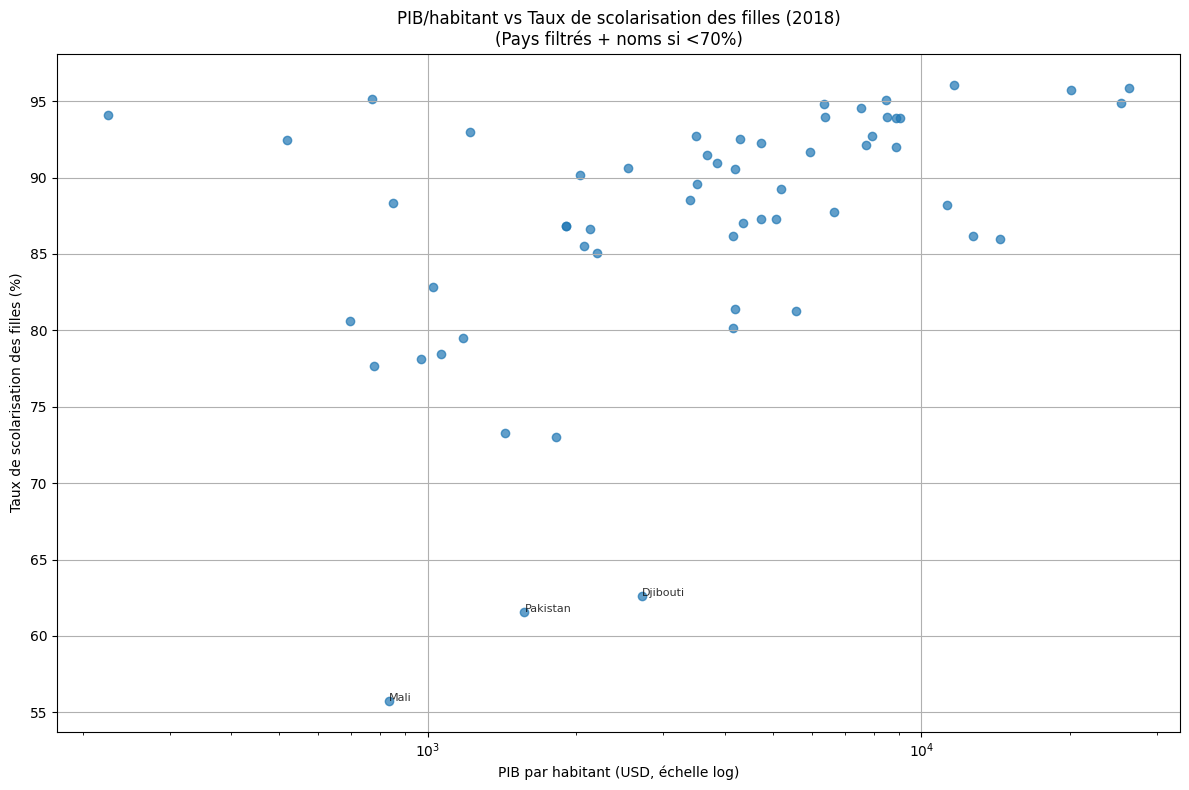

📈 Corrélation (2018) : 0.417


<ipython-input-12-d7d9a8a626e8>:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


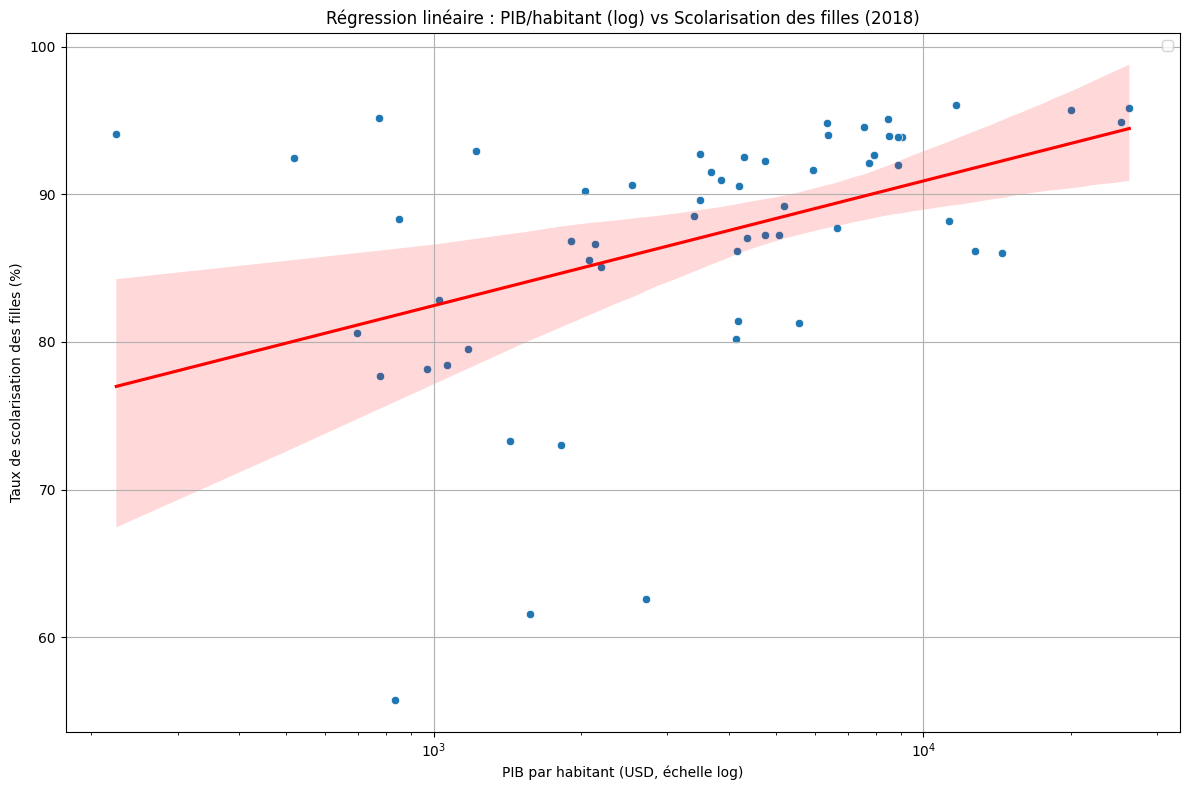

📊 Coefficients du modèle :
  - log_GDP_per_capita : 3.529
  - public_edu_spending : 1.153
🔁 Interception : 53.83
📐 R² (régression multiple) : 0.213


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression

# ----------------------------
# 1. Chargement des fichiers
# ----------------------------
df_pib = pd.read_csv("API_NY.GDP.PCAP.CD_DS2_en_csv_v2_85121.csv", skiprows=4)
df_edu = pd.read_csv("API_SE.PRM.NENR.FE_DS2_en_csv_v2_87242.csv", skiprows=4)
df_exp = pd.read_csv("API_SE.XPD.TOTL.GD.ZS_DS2_en_csv_v2_85113.csv", skiprows=4)

# ----------------------------
# 2. Transformation format long
# ----------------------------
df_pib_melted = df_pib.melt(id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
                            var_name="Year", value_name="GDP_per_capita")
df_edu_melted = df_edu.melt(id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
                            var_name="Year", value_name="Enrollment_rate_female")
df_exp_melted = df_exp.melt(
    id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
    var_name="Year",
    value_name="Public_edu_expenditure_pct_GDP"
)


# ----------------------------
# 3. Nettoyage
# ----------------------------
df_pib_clean = df_pib_melted[["Country Name", "Year", "GDP_per_capita"]].copy()
df_edu_clean = df_edu_melted[["Country Name", "Year", "Enrollment_rate_female"]].copy()

df_pib_clean.dropna(inplace=True)
df_edu_clean.dropna(inplace=True)

df_pib_clean["Year"] = df_pib_clean["Year"].astype(int)
df_edu_clean["Year"] = df_edu_clean["Year"].astype(int)

df_exp_clean = df_exp_melted[["Country Name", "Year", "Public_edu_expenditure_pct_GDP"]].copy()
df_exp_clean.dropna(inplace=True)
df_exp_clean["Year"] = df_exp_clean["Year"].astype(int)

# ----------------------------
# 4. Fusion des deux jeux de données
# ----------------------------
df_merged = pd.merge(df_pib_clean, df_edu_clean, on=["Country Name", "Year"])
print("✅ Données fusionnées :", len(df_merged))

df_full = pd.merge(df_merged, df_exp_clean, on=["Country Name", "Year"])
print("✅ Données enrichies :", len(df_full))
df_full.head()

# ----------------------------
# 5. Filtrer pour l'année 2018
# ----------------------------
df_2018 = df_full[df_full["Year"] == 2018]

# ----------------------------
# 6. Filtrer les pays pour lisibilité
# ----------------------------
df_2018_filtered = df_2018[
    (df_2018["GDP_per_capita"] < 30000) &
    (df_2018["Enrollment_rate_female"] > 40)
]

# Afficher le nombre de pays restants
print("📊 Pays filtrés :", len(df_2018_filtered))

# ----------------------------
# 7. Affichage graphique
# ----------------------------
plt.figure(figsize=(12, 8))

# Scatterplot
plt.scatter(df_2018_filtered["GDP_per_capita"], df_2018_filtered["Enrollment_rate_female"], alpha=0.7)

# Afficher uniquement les noms des pays sous-performants (<70%)
for i, row in df_2018_filtered.iterrows():
    if row["Enrollment_rate_female"] < 70:
        plt.text(row["GDP_per_capita"], row["Enrollment_rate_female"], row["Country Name"],
                 fontsize=8, alpha=0.8)

plt.xscale("log")
plt.title("PIB/habitant vs Taux de scolarisation des filles (2018)\n(Pays filtrés + noms si <70%)")
plt.xlabel("PIB par habitant (USD, échelle log)")
plt.ylabel("Taux de scolarisation des filles (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------
# 8. Corrélation sur les données filtrées
# ----------------------------
correlation_2018 = df_2018_filtered["GDP_per_capita"].corr(df_2018_filtered["Enrollment_rate_female"])
print("📈 Corrélation (2018) :", round(correlation_2018, 3))

plt.figure(figsize=(12, 8))

# Scatterplot
sns.scatterplot(data=df_2018_filtered, x="GDP_per_capita", y="Enrollment_rate_female")

# Régression linéaire avec échelle logarithmique sur X
sns.regplot(data=df_2018_filtered,
            x="GDP_per_capita", y="Enrollment_rate_female",
            scatter=False, logx=True,
            line_kws={"color": "red", "label": "Régression linéaire"})

plt.xscale("log")
plt.title("Régression linéaire : PIB/habitant (log) vs Scolarisation des filles (2018)")
plt.xlabel("PIB par habitant (USD, échelle log)")
plt.ylabel("Taux de scolarisation des filles (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Variables explicatives
X = pd.DataFrame({
    "log_GDP_per_capita": np.log(df_2018_filtered["GDP_per_capita"]),
    "public_edu_spending": df_2018_filtered["Public_edu_expenditure_pct_GDP"]
})

# Variable cible
y = df_2018_filtered["Enrollment_rate_female"]

model = LinearRegression()
model.fit(X, y)

# Coefficients
print("📊 Coefficients du modèle :")
for name, coef in zip(X.columns, model.coef_):
    print(f"  - {name} : {round(coef, 3)}")

# Ordonnée à l'origine
print("🔁 Interception :", round(model.intercept_, 3))

# R² global
r_squared = model.score(X, y)
print("📐 R² (régression multiple) :", round(r_squared, 3))

# 🎓 Projet Data – Scolarisation des filles & Développement économique national (Banque Mondiale)

**Objectif :** Analyser l'influence entre le développement économique d’un pays et ses investissements publics en éducation sur le taux de scolarisation des filles en école primaire dans le monde.

- Source : Données ouvertes de la Banque mondiale
- Outils : Python, Pandas, Seaborn, Scikit-learn
- Méthodologie : Visualisations, corrélations, régressions linéaires simples et multiples

**Compétences démontrées :**
- Collecte et nettoyage de données ouvertes
- Visualisation de données avec Matplotlib et Seaborn
- Régression simple et multiple avec Scikit-learn
- Interprétation critique de résultats statistiques

Ce projet a été mené en plusieurs étapes :
- Une première analyse a été réalisée sur les années 2015 et 2018, en étudiant uniquement la relation entre le développement économique du pays (PIB par habitant) et le taux de scolarisation des filles.
- Dans une seconde phase, le modèle a été enrichi avec une troisième variable : les dépenses publiques en éducation (en % du PIB), afin d'explorer une possible amélioration du pouvoir explicatif.


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 📥 1. Chargement et préparation des données

Téléchargement de 3 jeux de données de la Banque mondiale :
- PIB par habitant
- Taux net de scolarisation des filles (primaire)
- Dépenses publiques en éducation (% du PIB)

Les données sont transformées en format long puis nettoyées.

In [14]:
# ----------------------------
# 1. Chargement des fichiers
# ----------------------------
df_pib = pd.read_csv("API_NY.GDP.PCAP.CD_DS2_en_csv_v2_85121.csv", skiprows=4)
df_edu = pd.read_csv("API_SE.PRM.NENR.FE_DS2_en_csv_v2_87242.csv", skiprows=4)
df_exp = pd.read_csv("API_SE.XPD.TOTL.GD.ZS_DS2_en_csv_v2_85113.csv", skiprows=4)

# ----------------------------
# 2. Transformation format long
# ----------------------------
df_pib_melted = df_pib.melt(id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
                            var_name="Year", value_name="GDP_per_capita")
df_edu_melted = df_edu.melt(id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
                            var_name="Year", value_name="Enrollment_rate_female")
df_exp_melted = df_exp.melt(
    id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
    var_name="Year",
    value_name="Public_edu_expenditure_pct_GDP"
)

# ----------------------------
# 3. Nettoyage
# ----------------------------
df_pib_clean = df_pib_melted[["Country Name", "Year", "GDP_per_capita"]].copy()
df_edu_clean = df_edu_melted[["Country Name", "Year", "Enrollment_rate_female"]].copy()

df_pib_clean.dropna(inplace=True)
df_edu_clean.dropna(inplace=True)

df_pib_clean["Year"] = df_pib_clean["Year"].astype(int)
df_edu_clean["Year"] = df_edu_clean["Year"].astype(int)

df_exp_clean = df_exp_melted[["Country Name", "Year", "Public_edu_expenditure_pct_GDP"]].copy()
df_exp_clean.dropna(inplace=True)
df_exp_clean["Year"] = df_exp_clean["Year"].astype(int)

# ----------------------------
# 4. Fusion des deux jeux de données
# ----------------------------
df_merged = pd.merge(df_pib_clean, df_edu_clean, on=["Country Name", "Year"])
print("✅ Données fusionnées :", len(df_merged))

df_full = pd.merge(df_merged, df_exp_clean, on=["Country Name", "Year"])
print("✅ Données enrichies :", len(df_full))
df_full.head()

✅ Données fusionnées : 4966
✅ Données enrichies : 2814


,Country Name,Year,GDP_per_capita,Enrollment_rate_female,Public_edu_expenditure_pct_GDP
0,Argentina,1970,1322.714542,96.12037,1.45809
1,Guatemala,1970,352.790809,42.23365,1.85872
2,Panama,1970,892.890877,74.65225,4.04328
3,Paraguay,1970,248.996708,78.64393,2.10519
4,Bahrain,1971,1829.740705,67.22910,2.30781


## 📊 2. Analyse descriptive et visualisation

Analyse de la relation entre le PIB et le taux de scolarisation des filles pour deux années (2015 et 2018), avec affichage de scatterplots en échelle logarithmique.

📊 Pays filtrés : 58


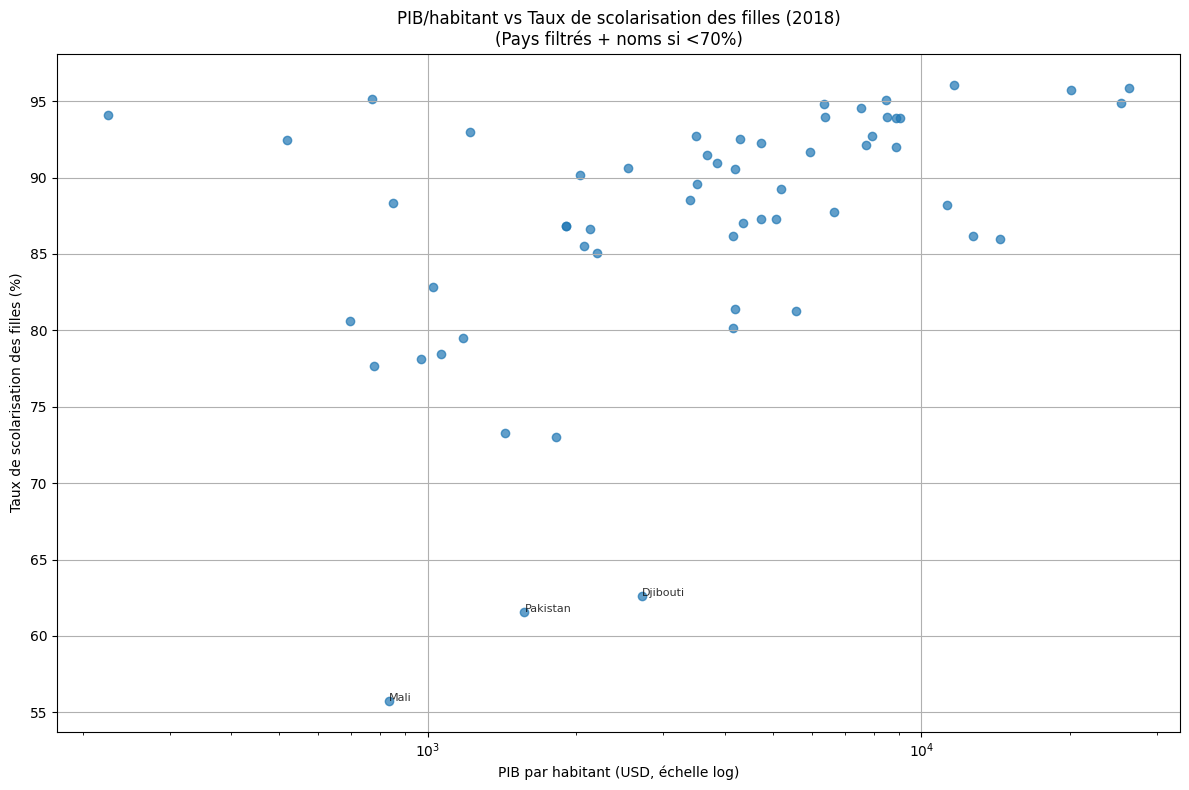

📈 Corrélation (2018) : 0.417


In [15]:
# ----------------------------
# 5. Filtrer pour l'année 2018
# ----------------------------
df_2018 = df_full[df_full["Year"] == 2018]

# ----------------------------
# 6. Filtrer les pays pour lisibilité
# ----------------------------
df_2018_filtered = df_2018[
    (df_2018["GDP_per_capita"] < 30000) &
    (df_2018["Enrollment_rate_female"] > 40)
]

# Afficher le nombre de pays restants
print("📊 Pays filtrés :", len(df_2018_filtered))

# ----------------------------
# 7. Affichage graphique
# ----------------------------
plt.figure(figsize=(12, 8))

# Scatterplot
plt.scatter(df_2018_filtered["GDP_per_capita"], df_2018_filtered["Enrollment_rate_female"], alpha=0.7)

# Afficher uniquement les noms des pays sous-performants (<70%)
for i, row in df_2018_filtered.iterrows():
    if row["Enrollment_rate_female"] < 70:
        plt.text(row["GDP_per_capita"], row["Enrollment_rate_female"], row["Country Name"],
                 fontsize=8, alpha=0.8)

plt.xscale("log")
plt.title("PIB/habitant vs Taux de scolarisation des filles (2018)\n(Pays filtrés + noms si <70%)")
plt.xlabel("PIB par habitant (USD, échelle log)")
plt.ylabel("Taux de scolarisation des filles (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------
# 8. Corrélation sur les données filtrées
# ----------------------------
correlation_2018 = df_2018_filtered["GDP_per_capita"].corr(df_2018_filtered["Enrollment_rate_female"])
print("📈 Corrélation (2018) :", round(correlation_2018, 3))

## 📈 3. Régressions linéaires

Régression simple (log(PIB) ➝ scolarisation) et régression multiple (log(PIB) + dépenses ➝ scolarisation), avec interprétation des coefficients et du R².

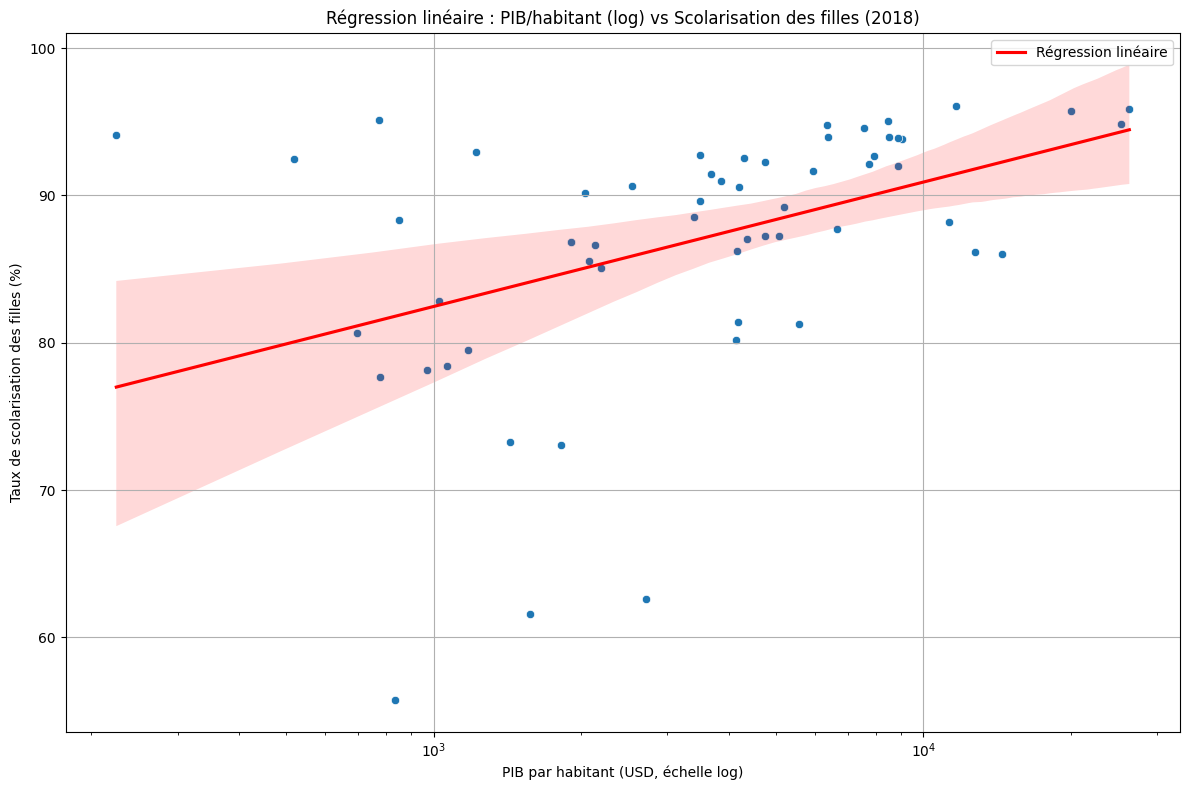

In [16]:
plt.figure(figsize=(12, 8))

# Scatterplot
sns.scatterplot(data=df_2018_filtered, x="GDP_per_capita", y="Enrollment_rate_female")

# Régression linéaire avec échelle logarithmique sur X
line = sns.regplot(data=df_2018_filtered,
                   x="GDP_per_capita", y="Enrollment_rate_female",
                   scatter=False, logx=True,
                   line_kws={"color": "red"})

line_line = line.lines[0]
line_line.set_label("Régression linéaire")
plt.legend(loc="upper right")

plt.xscale("log")
plt.title("Régression linéaire : PIB/habitant (log) vs Scolarisation des filles (2018)")
plt.xlabel("PIB par habitant (USD, échelle log)")
plt.ylabel("Taux de scolarisation des filles (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

## 🧪 Extension du modèle avec une 3e variable et résumé des analyses précédentes

Avant d'enrichir le modèle avec une 3e variable, plusieurs analyses ont été menées :

### 📅 Analyse 2015 (2 variables)
- **Corrélation** entre log(PIB/habitant) et scolarisation : **0.345**
- **R² de la régression simple :** 0.246

### 📅 Analyse 2018 (2 variables)
- **Corrélation** entre log(PIB/habitant) et scolarisation : **0.418**
- **R² de la régression simple :** 0.202

> Ces résultats suggèrent une corrélation positive modérée entre richesse et scolarisation, mais aussi une limite dans le pouvoir explicatif du PIB seul.

---

J'ai ensuite cherché à enrichir le modèle avec une 3e variable potentiellement influente : **les dépenses publiques en éducation**.

## 📈 4. Régression multiple

In [17]:
# Variables explicatives
X = pd.DataFrame({
    "log_GDP_per_capita": np.log(df_2018_filtered["GDP_per_capita"]),
    "public_edu_spending": df_2018_filtered["Public_edu_expenditure_pct_GDP"]
})

# Variable cible
y = df_2018_filtered["Enrollment_rate_female"]

model = LinearRegression()
model.fit(X, y)

# Coefficients
print("📊 Coefficients du modèle :")
for name, coef in zip(X.columns, model.coef_):
    print(f"  - {name} : {round(coef, 3)}")

# Ordonnée à l'origine
print("🔁 Interception :", round(model.intercept_, 3))

# R² global
r_squared = model.score(X, y)
print("📐 R² (régression multiple) :", round(r_squared, 3))

📊 Coefficients du modèle :
  - log_GDP_per_capita : 3.529
  - public_edu_spending : 1.153
🔁 Interception : 53.83
📐 R² (régression multiple) : 0.213


📌 Les résultats chiffrés du modèle sont jugés suffisamment clairs. Aucun graphique n'a été ajouté pour la régression multiple afin de préserver la lisibilité du notebook.

## ✅ 5. Conclusion

Ce projet permet d'aborder en surface et d’explorer les facteurs influençant l’éducation des filles à l’échelle mondiale.

- Le **PIB par habitant** est positivement corrélé à la scolarisation, mais ne l’explique que partiellement.
- L’ajout des **dépenses publiques en éducation** améliore le modèle, sans toutefois capturer toute la complexité du phénomène.

📌 Pour aller plus loin, on pourrait --

- ajouter d'autres années à l'analyse pour une comparaison temporelle plus étendue,
-  ajouter d'autres variables explicatives (IDH, égalité des genres, stabilité politique…),
- mettre en place un système de prédiction supervisée (régression multivariée avancée).